## uncomment this to install duck duck go and fastcore

In [8]:
#pip install ddgs

In [5]:
#pip install fastcore

In [11]:
#pip install fastdownload

In [13]:
#pip install fastai

## importing needed libs

In [2]:
from ddgs import DDGS # to search for the pics
from fastcore.all import * # extends core python libs to support things like deep learning.
import time, json

In [3]:
# function to pull images
def search_images(keywords, max_images=200):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [4]:
# lets search for a bird photo. we'll start by getting URL'S from a search
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

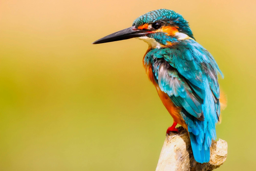

In [5]:
# now lets download and look at it
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import * # fast ai for deep learning
im = Image.open(dest)
im.to_thumb(256,256)

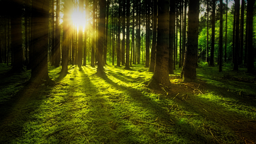

In [6]:
# now lets try for forest images
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [16]:
# our searches now work, lets grab a few more images of each and save them.

In [7]:
searches = 'bird', 'forest'
path = Path('bird_or_not')

if not path.exists():
    for i in searches:
        dest = (path/i)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{i} photo'))
        time.sleep(5) # pause for 5 seconds
        resize_images(path/i, max_size=400, dest=path/i)
    

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

## step 2: training our model.

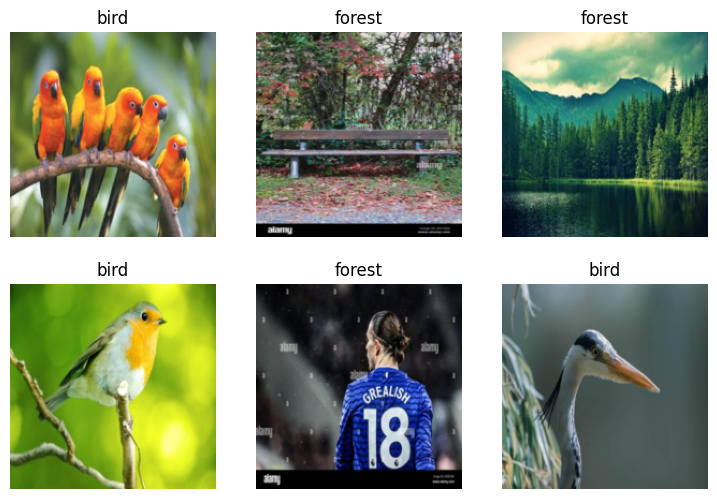

In [9]:
# start by creating a data block to see our images
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n = 6)

In [10]:
# now we train a neural net
import fastprogress
fastprogress.force_console_behavior()
# from fastai.callback.progress import ProgressCallback 
learn = cnn_learner(dls, 
                    resnet18,    # resnet18 means 18 layer cnn
                    metrics=error_rate
                    )  
# 🔥 REMOVE the notebook progress callback explicitly
learn.remove_cb(ProgressCallback)
learn.fine_tune(3) # like saying lean.fit()

/usr/local/python/3.12.1/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


[0, 1.5428342819213867, 1.3729926347732544, 0.3142856955528259, '00:15']
[0, 0.5101569294929504, 0.7989015579223633, 0.19999998807907104, '00:19']
[1, 0.328632652759552, 0.5283572673797607, 0.17142856121063232, '00:20']
[2, 0.2296636551618576, 0.3545354902744293, 0.05714285373687744, '00:19']


In [11]:
# lets test it by predicting using the image of bird we downloaded ealier

is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f'this is a:{is_bird}.')
print(f"probability it's a bird: {probs[0]:.4f}")

this is a:bird.
probability it's a bird: 1.0000
